# Week 7 Notebook: Model training, hyperparameter tuning, and model evaluation
The goal of this week's assignment is to use a second modeling method with 3 different hyperparameter settings of the method. 

### Import packages

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install --upgrade pandas
import seaborn as sns
import os
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, root_mean_squared_error


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 6.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.4.2 which is incompatible.


### Read data as dataframe

In [8]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

data_folder = os.path.join(parent_dir,"data")
raw_data_folder = os.path.join(data_folder,"raw")
interim_data_folder = os.path.join(data_folder,"interim")
processed_data_folder = os.path.join(data_folder, "processed")

In [9]:
# X data path
X_train_scaled_path = os.path.join(processed_data_folder, 'X_train_scaled.parquet')
X_val_scaled_path = os.path.join(processed_data_folder, 'X_val_scaled.parquet')
X_test_scaled_path = os.path.join(processed_data_folder, 'X_test_scaled.parquet')

train_pca_path = os.path.join(processed_data_folder, 'X_train_pca.parquet')
val_pca_path = os.path.join(processed_data_folder, 'X_val_pca.parquet')
test_pca_path = os.path.join(processed_data_folder, 'X_test_pca.parquet')
# Y data path
y_train_path = os.path.join(processed_data_folder, 'y_train.parquet')
y_val_path = os.path.join(processed_data_folder, 'y_val.parquet')
y_test_path = os.path.join(processed_data_folder, 'y_test.parquet')

In [10]:
# Reading the parquet files as dataframes
X_train_scaled = pd.read_parquet(X_train_scaled_path)
X_val_scaled = pd.read_parquet(X_val_scaled_path)
X_test_scaled = pd.read_parquet(X_test_scaled_path)

y_train = pd.read_parquet(y_train_path)
y_val = pd.read_parquet(y_val_path)
y_test = pd.read_parquet(y_test_path)

X_train_pca = pd.read_parquet(train_pca_path)
X_val_pca = pd.read_parquet(val_pca_path)
X_test_pca = pd.read_parquet(test_pca_path)

### Regression Tree
First, we tried to fit a regression tree model on our data without tuning any hyperparamters.

In [11]:
def evaluate_model(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    mse = rmse**2
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

In [12]:
# Initialize Decision Tree Regressor
dtr = DecisionTreeRegressor()
dtr.fit(X_train_scaled, y_train)

DecisionTreeRegressor()

In [14]:
# Predicting on training and test sets
y_train_pred_tree = dtr.predict(X_train_scaled)
y_test_pred_tree = dtr.predict(X_test_scaled)
y_val_pred_tree = dtr.predict(X_val_scaled)

# Evaluate performance
train_mse_tree, train_rmse_tree, train_r2_tree = evaluate_model(y_train, y_train_pred_tree)
val_mse_tree, val_rmse_tree, val_r2_tree = evaluate_model(y_val, y_val_pred_tree)

# Print training metrics
print("Decision Tree Regression Model - Training Metrics:")
print(f"MSE: {train_mse_tree:.4f}, RMSE: {train_rmse_tree:.4f}, R²: {train_r2_tree:.4f}")

# Print validation metrics
print("\nDecision Tree Regression Model - Validation Metrics:") 
print(f"MSE: {val_mse_tree:.4f}, RMSE: {val_rmse_tree:.4f}, R²: {val_r2_tree:.4f}")

Decision Tree Regression Model - Training Metrics:
MSE: 0.1008, RMSE: 0.3175, R²: 1.0000

Decision Tree Regression Model - Validation Metrics:
MSE: 6.5463, RMSE: 2.5586, R²: 0.9992


In [19]:
# 1. Actual depth of the tree
actual_depth = dtr.tree_.max_depth
print("Actual Depth:", actual_depth)

# 2. Number of leaves
num_leaves = dtr.tree_.n_leaves
print("Number of Leaves:", num_leaves)

# 3. Total number of nodes
node_count = dtr.tree_.node_count
print("Total Number of Nodes:", node_count)

Actual Depth: 48
Number of Leaves: 30893
Total Number of Nodes: 61785


### Hyperparameter Tuning

In [23]:
param_grid = {
    'max_depth': [5, 10, 20, 30],   # Limit the tree depth
    'min_samples_split': [2, 5, 10, 20],  # Increase the minimum samples required to split
    'min_samples_leaf': [5, 10, 15] # Increase the minimum samples per leaf
}

# Initialize Decision Tree Regressor
dtr = DecisionTreeRegressor()

# Perform Grid Search with cross-validation, including pruning
grid_search = GridSearchCV(dtr, param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model after hyperparameter tuning
best_tree = grid_search.best_estimator_

# Print best parameters
print(f"Best hyperparameters for Decision Tree: {grid_search.best_params_}")

Best hyperparameters for Decision Tree: {'max_depth': 20, 'min_samples_leaf': 15, 'min_samples_split': 2}


In [25]:
# Predicting on training and test sets
y_train_pred_tree = best_tree.predict(X_train_scaled)
y_test_pred_tree = best_tree.predict(X_test_scaled)
y_val_pred_tree = best_tree.predict(X_val_scaled)

# Evaluate performance
train_mse_tree, train_rmse_tree, train_r2_tree = evaluate_model(y_train, y_train_pred_tree)
test_mse_tree, test_rmse_tree, test_r2_tree = evaluate_model(y_test, y_test_pred_tree)
val_mse_tree, val_rmse_tree, val_r2_tree = evaluate_model(y_val, y_val_pred_tree)

# Print training metrics
print("Decision Tree Regression Model - Training Metrics:")
print(f"MSE: {train_mse_tree:.4f}, RMSE: {train_rmse_tree:.4f}, R²: {train_r2_tree:.4f}")

# Print validation metrics
print("\nDecision Tree Regression Model - Validation Metrics:")
print(f"MSE: {val_mse_tree:.4f}, RMSE: {val_rmse_tree:.4f}, R²: {val_r2_tree:.4f}")

# Print test metrics
print("\nDecision Tree Regression Model - Test Metrics:")
print(f"MSE: {test_mse_tree:.4f}, RMSE: {test_rmse_tree:.4f}, R²: {test_r2_tree:.4f}")

Decision Tree Regression Model - Training Metrics:
MSE: 2.2741, RMSE: 1.5080, R²: 0.9997

Decision Tree Regression Model - Validation Metrics:
MSE: 3.7708, RMSE: 1.9419, R²: 0.9995

Decision Tree Regression Model - Test Metrics:
MSE: 4.1432, RMSE: 2.0355, R²: 0.9996


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


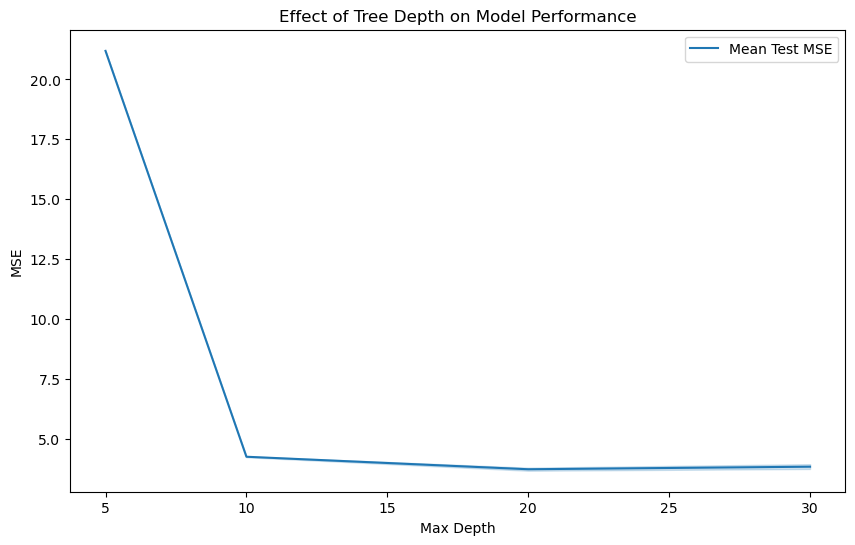

In [32]:
# Comparing multiple hyperparameter settings
results = pd.DataFrame(grid_search.cv_results_)


# Plotting RMSE vs hyperparameters
plt.figure(figsize=(10, 6))
sns.lineplot(x=results['param_max_depth'], y=-results['mean_test_score'], label='Mean Test MSE')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.title('Effect of Tree Depth on Model Performance')
plt.legend()
plt.show()

In [36]:
# Update the hyperparameter grid to include smaller depths, and larger sample splits/leaves
param_grid = {
    'max_depth': [10, 20, 30],  
    'min_samples_split': [2, 5, 7],  # Increase the minimum samples required to split a node to prevent the tree from growing too deep
    'min_samples_leaf': [5, 10, 15],  # Increase the minimum samples required in a leaf node to make the tree more generalized
    'ccp_alpha': [0.001, 0.01, 0.1]  # Increase pruning to avoid overly complex trees
}

# Initialize Decision Tree Regressor
dtr = DecisionTreeRegressor()

# Perform Grid Search with cross-validation, including pruning
grid_search = GridSearchCV(dtr, param_grid, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model after hyperparameter tuning
best_tree = grid_search.best_estimator_

# Print best parameters
print(f"Best hyperparameters for Decision Tree: {grid_search.best_params_}")

Best hyperparameters for Decision Tree: {'ccp_alpha': 0.001, 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2}


In [35]:
# Predicting on training and test sets
y_train_pred_tree = best_tree.predict(X_train_scaled)
y_test_pred_tree = best_tree.predict(X_test_scaled)
y_val_pred_tree = best_tree.predict(X_val_scaled)

# Evaluate performance
train_mse_tree, train_rmse_tree, train_r2_tree = evaluate_model(y_train, y_train_pred_tree)
test_mse_tree, test_rmse_tree, test_r2_tree = evaluate_model(y_test, y_test_pred_tree)
val_mse_tree, val_rmse_tree, val_r2_tree = evaluate_model(y_val, y_val_pred_tree)

# Print training metrics
print("Decision Tree Regression Model - Training Metrics:")
print(f"MSE: {train_mse_tree:.4f}, RMSE: {train_rmse_tree:.4f}, R²: {train_r2_tree:.4f}")

# Print test metrics
print("\nDecision Tree Regression Model - Test Metrics:")
print(f"MSE: {test_mse_tree:.4f}, RMSE: {test_rmse_tree:.4f}, R²: {test_r2_tree:.4f}")

# Print validation metrics
print("\nDecision Tree Regression Model - Validation Metrics:")  # Add this block for validation metrics
print(f"MSE: {val_mse_tree:.4f}, RMSE: {val_rmse_tree:.4f}, R²: {val_r2_tree:.4f}")

Decision Tree Regression Model - Training Metrics:
MSE: 2.6242, RMSE: 1.6200, R²: 0.9997

Decision Tree Regression Model - Test Metrics:
MSE: 3.8334, RMSE: 1.9579, R²: 0.9996

Decision Tree Regression Model - Validation Metrics:
MSE: 3.3819, RMSE: 1.8390, R²: 0.9996


In [44]:
# Comparing multiple hyperparameter settings
results = pd.DataFrame(grid_search.cv_results_)
results.replace([np.inf, -np.inf], np.nan, inplace=True)

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


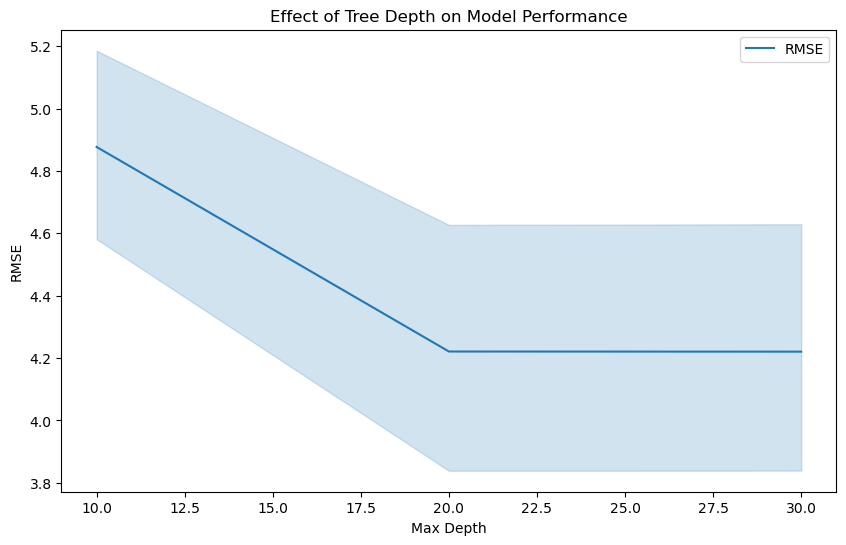

In [45]:
# Plotting RMSE vs hyperparameters
plt.figure(figsize=(10, 6))
sns.lineplot(x=results['param_max_depth'], y=-results['mean_test_score'], label='RMSE')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.title('Effect of Tree Depth on Model Performance')
plt.legend()
plt.show()

In [45]:
# Get the feature importances from the best tree
feature_importances = best_tree.feature_importances_

# Create a DataFrame to display feature importance
features_df = pd.DataFrame({'Feature': X_train_scaled.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(features_df)

                         Feature  Importance
56       source_Theatre_District    0.448210
68  destination_Theatre_District    0.401432
78                     name_Taxi    0.141550
71                name_Black_SUV    0.002291
74             name_Lux_Black_XL    0.002280
..                           ...         ...
40    apparentTemperatureMinTime    0.000000
41        apparentTemperatureMax    0.000000
43                     rush_hour    0.000000
44                       weekend    0.000000
83                 cab_type_Uber    0.000000

[84 rows x 2 columns]


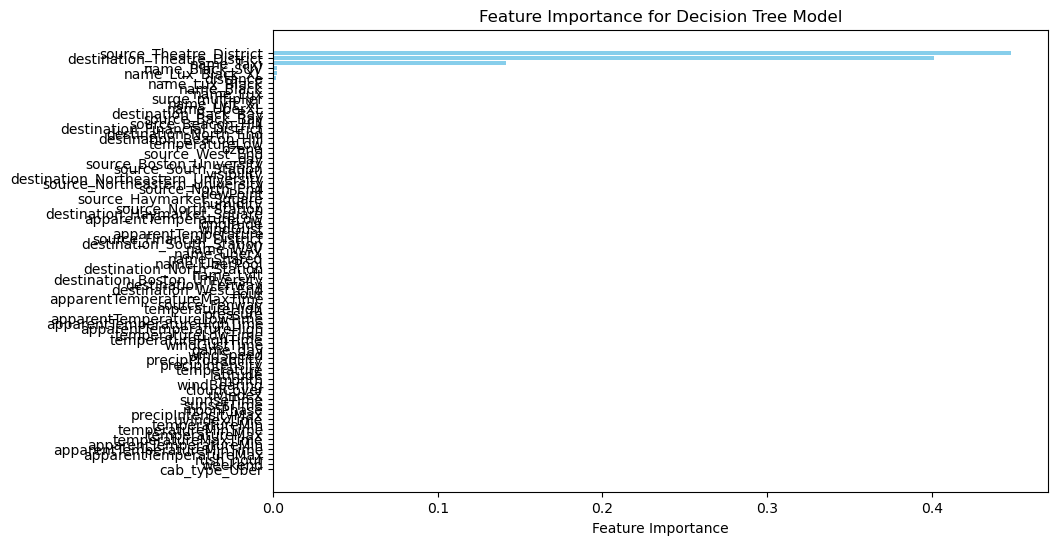